# Data

Data set of 450 bird species. 70,626 training images, 22500 test images(5 images per species) and 2250 validation images(5 images per species. This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderately complex model will achieve training and test accuracies in the mid 90% range.

All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 450 sub directories, one for each bird species. The data structure is convenient if you use the Keras ImageDataGenerator.flow_from_directory to create the train, test and valid data generators. The data set also include a file birds.csv. This cvs file contains 5 columns. The filepaths column contains the relative file path to an image file. The labels column contains the bird species class name associated with the image file. The scientific label column contains the latin scientific name for the image. The data set column denotes which dataset (train, test or valid) the filepath resides in. The class_id column contains the class index value associated with the image file's class. To see how to use the csv file see my notebook Birds 450 using CSV to create train, test and valid dataframes.

NOTE: The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images.

# Load Data

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

import pandas as pd

Add [birds species](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) data set to Notebook. An easy way to do this is to navigate to the data set and click **New Notebook** button at top-right.

Set path to data set location.

In [2]:
path = Path('/kaggle/input/100-bird-species')

[Folder structure](https://github.com/himalayahall/YU_FASTAI/blob/e1cb5b2c271a51bcaf416985a99bf5c5aae567ba/Kaggle-Birds-450-Species-Screenshot.jpg) shows data is laid out in train/test/valid folders. In addition, the **birds.csv** file provides a comprehensive listing of all bird images along with their categories and train/test/valid partition.

Within train/test/valid folders are multiple folders, one per species, containing images. 

This provides us a few different strategies available for data loading:

1. Use birds.csv to load data
2. Use folder structure to load data

Data sets are frequently provided in one of these two formats (if one is lucky!). We will use the first data loading strategy.

We will load **birds.csv** into a Pandas dataframe. 

In [3]:
df = pd.read_csv(path/'birds.csv')

Examine data.

In [4]:
df.head()

,class id,filepaths,labels,scientific label,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train


# Build DataBlock

For image classification in fast.ai, we have to provide functions for getting the predictor variable (x) and the class label (y). The parameter to both functions will be a **pandas series** with one data frame row. 

For the predictor variable, **get_x** will return the full path of the image file: **path/filepaths**. 

For the class label, variable, **get_y** returns the **labels**. 

In [5]:
def get_x(r) : return path/r.filepaths
def get_y(r) : return r.labels

Let's create a simple **DataBlock** to verify our strategy works as expected.

In [6]:
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/kaggle/input/100-bird-species/train/AUCKLAND SHAQ/105.jpg'),
 'AUCKLAND SHAQ')

In [7]:
# import warnings
# try:
#     import torch_xla
# except ImportError as e:
#     warnings.warn('TPU environment not available')

Next, we create a custom **splitter** function to separate the dataframe into train/valid partitions and return the partition indices as lists.

In [8]:
# def splitter(df):
#     train = df.index[df['data set'] == 'train'].tolist() 
#     valid = df.index[df['data set'] == 'valid'].tolist() 
#     return train,valid

In [9]:
# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#             splitter = splitter,
#             get_y = get_y,
#             get_x = get_x,
#             item_tfms=[Resize(220, method='squish')],
#             batch_tfms=aug_transforms()
#                   )
# dls = dblock.dataloaders(df)
# dls.show_batch(max_n=9, nrows=3)

The most efficient way (to avoid iterating over the rows of the dataframe, which can take a long time) is to use the from_columns method. It will use get_items to convert the columns into numpy arrays. 

The drawback is that since we lose the dataframe after extracting the relevant columns, we can’t use a ColSplitter anymore. 

Here we used an IndexSplitter after manually extracting the index of the validation set from the dataframe:

In [10]:
def _bird_items(x): 
    return (f'{path}/'+x.filepaths, x.labels)

valid_idx = df.index[df['data set'] == 'valid'].values

The way we usually build the data block in one go is by answering a list of questions:

- what is the types of your inputs/targets? Here images and categories

- where is your data? Here in data frame columns (labels and image file names) and in folders (image files)

- does something need to be applied to inputs? Here the get_x function

- does something need to be applied to the target? Here the get_y function

- how to split the data? Here the splitter function

- do we need to apply something on formed items? Here a resize (necessary for processing tensors on GPUs) 

- do we need to apply something on formed batches? Here augmentation transforms


In [11]:
dblock = DataBlock.from_columns(blocks=(ImageBlock, CategoryBlock),
            splitter = IndexSplitter(valid_idx),
            get_items = _bird_items,
            item_tfms=[Resize(220, method='squish')],
            batch_tfms=aug_transforms()
            )
dls = dblock.dataloaders(df)

Let's verify that dataloader was created successfully.

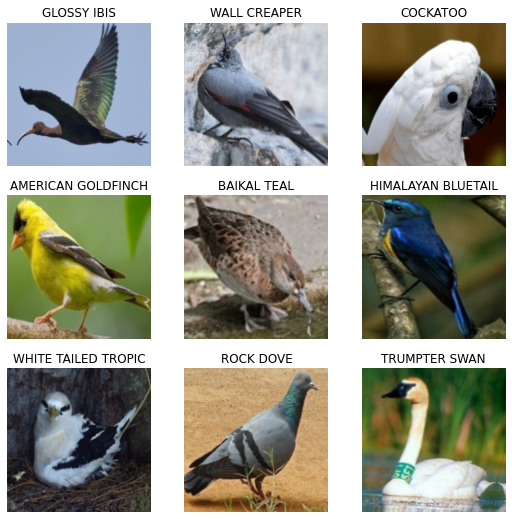

In [12]:
dls.show_batch(max_n=9, nrows=3)

# Build Learner

Now that dataloader was successfully created we can create our learner. Note: report **error_rate** and **accuracy** during training.

In [13]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Find the optimal learning rate for our image classification.

SuggestedLRs(valley=0.0012022644514217973)

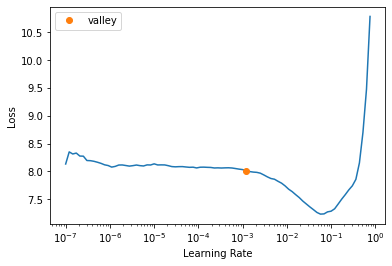

In [14]:
lr = learn.lr_find()
lr

In [15]:
base_lr=round(lr[0], 4)
base_lr

0.0012

Use the suggested LR to fine-tune model.

In [16]:
learn.fine_tune(3, base_lr=base_lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.563416,0.628188,0.154667,0.845333,07:27


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.827638,0.285051,0.074222,0.925778,05:09
1,0.508264,0.142212,0.038667,0.961333,05:09
2,0.379354,0.126810,0.034222,0.965778,05:10


Plot training/validation loss graph.

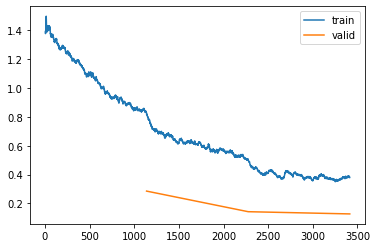

In [17]:
learn.recorder.plot_loss()

Show top losses.

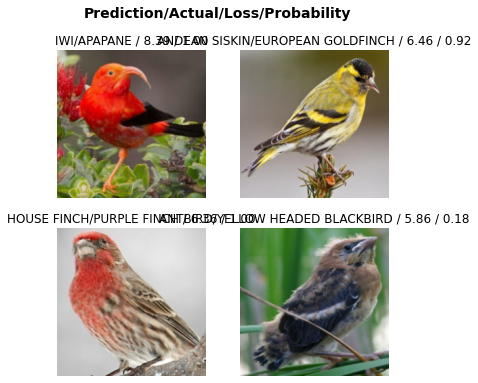

In [18]:
interp = ClassificationInterpretation.from_learner (learn)
interp.plot_top_losses(4, nrows=2)

In [19]:
# We have 400 bird species and displaying 400x400 confusion matrix is a problem!
# interp.confusion_matrix()

In [20]:
interp.most_confused()

[('GILDED FLICKER', 'NORTHERN FLICKER', 3),
 ('PURPLE FINCH', 'HOUSE FINCH', 3),
 ('GREATOR SAGE GROUSE', 'BLUE GROUSE', 2),
 ('SKUA', 'POMARINE JAEGER', 2),
 ('TRICOLORED BLACKBIRD', 'RED WINGED BLACKBIRD', 2),
 ('AFRICAN PIED HORNBILL', 'BLUE MALKOHA', 1),
 ('AFRICAN PIED HORNBILL', 'LESSER ADJUTANT', 1),
 ('AMERICAN PIPIT', 'ASHY THRUSHBIRD', 1),
 ('AMERICAN WIGEON', 'TEAL DUCK', 1),
 ('ANHINGA', 'DOUBLE BRESTED CORMARANT', 1),
 ('APAPANE', 'IWI', 1),
 ('ASHY STORM PETREL', 'GREY CUCKOOSHRIKE', 1),
 ('AUCKLAND SHAQ', 'RED FACED CORMORANT', 1),
 ('AUSTRALASIAN FIGBIRD', 'RED BROWED FINCH', 1),
 ('AVADAVAT', 'STRAWBERRY FINCH', 1),
 ('AZARAS SPINETAIL', 'FAN TAILED WIDOW', 1),
 ('AZURE JAY', 'AZURE TANAGER', 1),
 ('BARRED PUFFBIRD', 'ANTBIRD', 1),
 ('BLACK BAZA', 'NORTHERN MOCKINGBIRD', 1),
 ('BLACK FRANCOLIN', 'BAND TAILED GUAN', 1),
 ('BLUE COAU', 'BLUE MALKOHA', 1),
 ('BLUE DACNIS', 'BORNEAN LEAFBIRD', 1),
 ('BREWERS BLACKBIRD', 'ASIAN DOLLARD BIRD', 1),
 ('CANARY', 'AUSTRAL CANAST

In [21]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Using the Model for Inference

Save trained model in 'birds.pkl'

In [22]:
learn.export(fname='birds.pkl')

Verify model was saved successfully.

In [23]:
curr_path = Path()
curr_path.ls(file_exts='.pkl')

(#1) [Path('birds.pkl')]

Load saved model.

In [24]:
learn_inf = load_learner(curr_path/'birds.pkl')

Use model to predict.

In [25]:
learn_inf.predict(path/'images to test'/'firefinch.jpg')

('AFRICAN FIREFINCH',
 TensorBase(5),
 TensorBase([9.1516e-06, 2.0070e-08, 8.5466e-08, 1.3706e-08, 1.7442e-08, 9.6218e-01,
         2.9849e-05, 1.8037e-09, 9.0245e-07, 4.6854e-05, 8.0151e-05, 2.5911e-07,
         8.8707e-09, 1.5276e-08, 6.4705e-09, 2.0430e-07, 2.7666e-06, 1.6664e-07,
         1.8859e-08, 1.2860e-08, 1.2433e-08, 5.0602e-09, 5.7749e-08, 1.3292e-06,
         2.5325e-06, 1.8466e-07, 4.6006e-09, 1.4283e-05, 2.1522e-05, 6.8711e-09,
         9.1916e-09, 2.4784e-05, 7.7499e-07, 1.1920e-06, 1.0030e-07, 1.6378e-07,
         6.0624e-05, 2.4134e-05, 1.1849e-09, 2.1055e-07, 2.1782e-07, 3.0083e-04,
         1.7677e-05, 3.7009e-08, 3.2780e-08, 9.4561e-07, 3.1746e-08, 5.8455e-08,
         6.1869e-07, 2.5879e-04, 9.2617e-09, 2.9713e-09, 3.3783e-09, 1.3399e-07,
         2.1571e-06, 6.0442e-08, 9.5957e-08, 2.8174e-07, 1.1041e-05, 5.4168e-08,
         5.2850e-06, 1.2121e-07, 1.7120e-08, 1.7963e-05, 1.5657e-06, 8.8922e-08,
         4.3740e-09, 3.0894e-07, 3.4672e-08, 5.7681e-07, 2.3248e-07

In [26]:
from fastai.vision.widgets import *

Create file upload button.

In [27]:
btn_upload = widgets.FileUpload()

In [28]:
out_pl = widgets.Output()

Create predicted class label.

In [29]:
lbl_pred = widgets.Label()

Create callback function to predict label for uploaded image.

In [30]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: 
        display(img.to_thumb(128,128))
        pred, pred_idx, probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

Create button to trigger classification and register callback.

In [31]:
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)

Create vertical box with widgets for application.

In [32]:
VBox([widgets.Label('Select your bird!'), btn_upload, btn_run, out_pl, lbl_pred])

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and shows only output (including ipywidgets), along with your Markdown cells. So what’s left is a web application! To view your notebook as a Voilà web application, replace the word “notebooks” in your browser’s URL with “voila/render”. You will see the same content as your notebook, but without any of the code cells.

In [33]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.0 OK
